In [1]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import requests
%matplotlib inline

In [215]:
def get_game_hashes():
    r = requests.get("https://calculated.gg/api/v1/replays?key=1&minrank=19&playlist=13&year=2019&num=100&page=2").json()['data']
    return [g['hash'] for g in r]

def get_games():
    games = []
    hashes = get_game_hashes()
    for hash_ in hashes:
        r = requests.get("https://calculated.gg/api/v1/replay/{}?key=1".format(hash_))
        games.append(r.json())
    return games

def get_match_history(id_):
    r = requests.get("https://calculated.gg/api/replay?page=0&limit=1&player_ids={}&playlists=13".format(id_))
    return r.json()

def get_replay_count(id_):
    r = get_match_history(id_)
    return r['totalCount']

def get_player_stats(id_: str):
    r = requests.get("https://calculated.gg/api/player/{}/play_style/all".format(id_))
    return r.json()['dataPoints']

In [216]:
player_count_map = {}
player_stat_map = {}

In [217]:
data = []
games = get_games()
for game in games:
    skip_game = False
    metadata = game['gameMetadata']
    winner = 0
    print(game.keys())
    if metadata['score']['team0Score'] > metadata['score']['team1Score']:
        winner = 0
    elif metadata['score']['team0Score'] < metadata['score']['team1Score']:
        winner = 1
    else:
        continue # tied
    blue_dfs = []
    orange_dfs = []
    for player in game['players']:
        p = player['id']['id']
        if p in player_count_map:
            count = player_count_map[p]
        else:
            count = get_replay_count(p)
            player_count_map[p] = count
        
        if count < 10:
            skip_game = True
            break
        if p in player_stat_map:
            stats = player_stat_map[p]
        else:
            try:
                stats = get_player_stats(p)
            except:
                skip_game = True
                break
            player_stat_map[p] = stats
        statdf = pd.DataFrame(stats).set_index("name")
        if player['isOrange'] == 0:
            blue_dfs.append(statdf)
        elif player['isOrange'] == 1:
            orange_dfs.append(statdf)
    if skip_game:
        continue
    
    data.append({
        "blue0": blue_dfs[0],
        "blue1": blue_dfs[1],
        "blue2": blue_dfs[2],
        "orange0": orange_dfs[0],
        "orange1": orange_dfs[2],
        "orange2": orange_dfs[2],
        "result": winner
    })

dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'ga

dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'ga

In [218]:
data[0]['blue0'].T.head()

name,score,goals,assists,saves,shots,boost usage,num small boosts,num large boosts,wasted collection,wasted usage,...,passes/hit,assists/hit,useful/hits,shot %,collection boost efficiency,used boost efficiency,total boost efficiency,turnover efficiency,boost ratio,aerial efficiency
average,337.848504,0.605649,0.723824,1.211297,2.437366,2139.790161,87.700869,18.745562,598.034195,241.036269,...,26.809524,2.761905,38.904762,0.248485,0.796516,0.887108,0.713554,76.285714,4.444444,29.390788


In [219]:
import itertools

In [220]:
def process_data(dat):
    overall_dfs = []
    for game in dat:
        for perm in itertools.permutations(range(3)):
            dfs  = []
            for l, i in enumerate(perm):
                selected = game['blue'+str(i)].T
                dfs.append(selected.rename(columns={c: 'b'+str(l)+c for c in selected.columns}))
            for perm2 in itertools.permutations(range(3)):
                dfs2 = []
                for l, i in enumerate(perm2):
                    selected = game['orange'+str(i)].T
                    dfs2.append(selected.rename(columns={c: 'o'+str(l)+c for c in selected.columns}))
                df = pd.concat(dfs + dfs2, axis=1)
                df['result'] = game['result']
                overall_dfs.append(df)
    return pd.concat(overall_dfs)

In [221]:
train_input[0].shape

(444,)

In [259]:

df = process_data(data)

In [276]:
input = df.drop("result", axis=1)
# input = (input - input.min()) / (input.max() - input.min())
input = input.dropna(axis=1) # drop all nans
output = df["result"]

In [277]:
threshold = np.random.rand(len(df)) < 0.9
train_input, train_output = input[threshold].values, output[threshold].values
test_input, test_output = input[~threshold].values, output[~threshold].values

In [278]:
num_columns = len(input.columns)
n_hidden = 128
class ResultPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            nn.Linear(n_hidden//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, game_state):
        game_state = torch.from_numpy(game_state).float().cuda()
        return self.layers(game_state)

In [279]:
train_input[0]

array([3.37848504e+02, 6.05648579e-01, 7.23823912e-01, 1.21129716e+00,
       2.43736623e+00, 2.13979016e+03, 8.77008687e+01, 1.87455621e+01,
       5.98034195e+02, 2.41036269e+02, 1.59028040e+01, 9.36119555e+01,
       3.13344914e+01, 3.73729489e+00, 1.15828907e+02, 5.47054594e+02,
       5.09795970e+01, 4.88053488e+04, 5.26169480e+03, 5.45009974e+01,
       4.55688181e+01, 2.35490517e+01, 7.46140005e+01, 1.83767083e+01,
       5.41206910e+01, 5.87922279e+00, 2.52599773e+00, 2.52599773e+00,
       7.90297536e+00, 1.56720324e+02, 1.24543219e+02, 1.87268230e+01,
       1.80558875e+02, 1.19441124e+02, 1.25573797e+02, 1.04446827e+02,
       6.99793769e+01, 2.14359964e+02, 8.56352310e+01, 6.05766542e+01,
       3.49588660e+00, 1.51975799e+04, 2.62920976e+03, 2.15491444e+03,
       3.02676570e+01, 8.86314994e-02, 6.60304671e+00, 5.02245163e-01,
       1.62491082e+00, 5.50992488e+00, 5.43606530e+00, 1.30879181e+01,
       6.30000000e+01, 2.33671935e+01, 3.55812884e+01, 1.71643864e+02,
      

In [280]:
model = ResultPredictor().cuda().train()
opt = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.BCELoss()
epochs = int(100)
epoch_losses = []
accuracy = []

output_tensor = torch.from_numpy(train_output[np.newaxis].T).float().cuda()

for epoch in range(epochs):
    opt.zero_grad()
    predicted_train = model(train_input)
    loss_val = loss(predicted_train, output_tensor)
    loss_val.backward()
    opt.step()
    
    predicted = model(test_input)
    predicted = predicted.cpu().detach().numpy().astype(float)
#     print(predicted.shape, output_test.shape)
#     assert(predicted.shape == output_test.shape)#, "{}, {}".format(predicted.shape, output_test.shape))
    acc = ((predicted.T.astype(float) > 0.5) == (test_output == 1)).sum() / predicted.shape[0]
    epoch_losses.append(loss_val.cpu().data.numpy())
    accuracy.append(acc)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
(predicted.astype(float) > 0.5)[:5]

In [ ]:
plt.plot(range(len(epoch_losses)), epoch_losses);

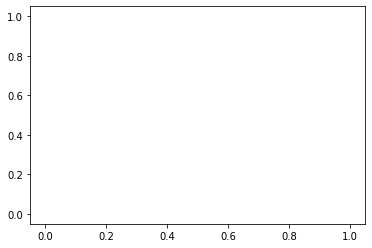

In [265]:
plt.plot(range(len(accuracy)), accuracy);